# import

In [15]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns

# LLM response, Ground Truth and participants

In [16]:
np.random.seed(42)

NUM_NFRS = 20
NUM_PARTICIPANTS = 2

In [17]:
satisfaction_levels = ['Satisfied', 'Weakly Satisfied', 'Weakly Denied', 'Denied', 'NA']

ground_truth_data = {
    'nfr_id': [f'NFR_{i+1}' for i in range(NUM_NFRS)],
    'satisfaction_level': np.random.choice(satisfaction_levels, NUM_NFRS),
    'reasoning_text': [f'Reasoning for NFR_{i+1}: The system uses encryption and proper authentication.' for i in range(NUM_NFRS)],
    'code_locations': [[f'file_{i}.py:lines_10-20', f'file_{i}.py:lines_45-50'] for i in range(NUM_NFRS)],
}

llm_response_data = {
    'nfr_id': [f'NFR_{i+1}' for i in range(NUM_NFRS)],
    'satisfaction_level': [],
    'reasoning_text': [],
    'code_locations': [],
}

for i in range(NUM_NFRS):
    if np.random.random() < 0.8:
        llm_response_data['satisfaction_level'].append(ground_truth_data['satisfaction_level'][i])
    else:
        other_levels = [l for l in satisfaction_levels if l != ground_truth_data['satisfaction_level'][i]]
        llm_response_data['satisfaction_level'].append(np.random.choice(other_levels))
    
    if np.random.random() < 0.85:
        llm_response_data['reasoning_text'].append(ground_truth_data['reasoning_text'][i])
    else:
        llm_response_data['reasoning_text'].append(f'Reasoning for NFR_{i+1}: Alternative explanation with different focus.')
    
    gt_locations = ground_truth_data['code_locations'][i]
    if np.random.random() < 0.75:
        llm_response_data['code_locations'].append(gt_locations)
    else:
        partial = gt_locations[:1] + [f'file_{i}_wrong.py:lines_30-35']
        llm_response_data['code_locations'].append(partial)

df_ground_truth = pd.DataFrame(ground_truth_data)
df_llm_response = pd.DataFrame(llm_response_data)


In [18]:
agreement_levels = ['Agree', 'Partially Agree', 'Partially Disagree', 'Disagree']
participant_nfr_data = []
for participant_id in range(1, NUM_PARTICIPANTS + 1):    
    for nfr_idx in range(1, NUM_NFRS + 1):
        nfr_id = f'NFR_{nfr_idx}'
        gt_level = ground_truth_data['satisfaction_level'][nfr_idx - 1]
        gt_reason = ground_truth_data['reasoning_text'][nfr_idx - 1]
        gt_locations = ground_truth_data['code_locations'][nfr_idx - 1]

        participant_level = gt_level if np.random.random() < 0.8 else np.random.choice(
            [lvl for lvl in satisfaction_levels if lvl != gt_level]
        )
        participant_reason = gt_reason if np.random.random() < 0.8 else f'Participant {participant_id} alternative reasoning for {nfr_id}.'
        participant_locations = gt_locations if np.random.random() < 0.8 else gt_locations[:1] + [f'file_{nfr_idx}_alt.py:lines_5-15']

        if np.random.random() < 0.8:
            q1_agreement = 'Agree'
        else:
            q1_agreement = np.random.choice([lvl for lvl in agreement_levels if lvl != 'Agree'])

        if np.random.random() < 0.8:
            q2_agreement = 'Agree'
        else:
            q2_agreement = np.random.choice([lvl for lvl in agreement_levels if lvl != 'Agree'])

        if np.random.random() < 0.8:
            q3_agreement = 'Agree'
        else:
            q3_agreement = np.random.choice([lvl for lvl in agreement_levels if lvl != 'Agree'])

        participant_nfr_data.append({
            'participant_id': participant_id,
            'nfr_id': nfr_id,
            'q1_satisfaction_agreement': q1_agreement,
            'q2_reasoning_agreement': q2_agreement,
            'q3_code_location_agreement': q3_agreement,
            'participant_satisfaction_level': participant_level,
            'participant_reasoning_text': participant_reason,
            'participant_code_locations': participant_locations,
        })

df_participant_nfr = pd.DataFrame(participant_nfr_data)
df_participant_nfr.head()

,participant_id,nfr_id,q1_satisfaction_agreement,q2_reasoning_agreement,q3_code_location_agreement,participant_satisfaction_level,participant_reasoning_text,participant_code_locations
0,1,NFR_1,Agree,Agree,Agree,Denied,Participant 1 alternative reasoning for NFR_1.,"[file_0.py:lines_10-20, file_1_alt.py:lines_5-15]"
1,1,NFR_2,Agree,Agree,Agree,NA,Reasoning for NFR_2: The system uses encryptio...,"[file_1.py:lines_10-20, file_1.py:lines_45-50]"
2,1,NFR_3,Agree,Agree,Agree,Denied,Reasoning for NFR_3: The system uses encryptio...,"[file_2.py:lines_10-20, file_2.py:lines_45-50]"
3,1,NFR_4,Agree,Agree,Agree,NA,Reasoning for NFR_4: The system uses encryptio...,"[file_3.py:lines_10-20, file_3.py:lines_45-50]"
4,1,NFR_5,Agree,Agree,Agree,NA,Participant 1 alternative reasoning for NFR_5.,"[file_4.py:lines_10-20, file_4.py:lines_45-50]"


# RQ1

## Agreement

### Satisfaction Level

            agreement  count  percent
0               Agree     31     77.5
1     Partially Agree      3      7.5
2  Partially Disagree      3      7.5
3            Disagree      3      7.5


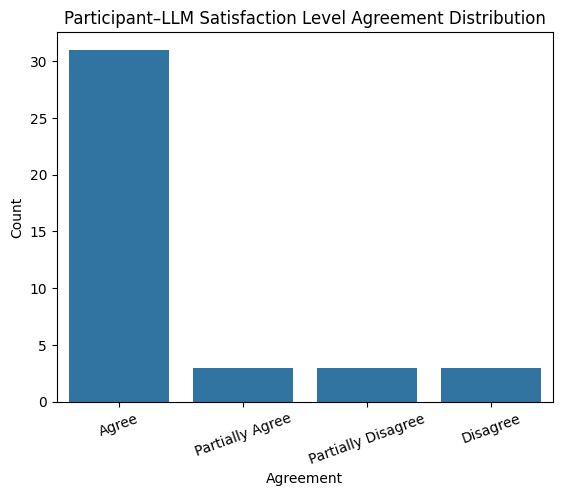

In [19]:
agreement_cat = pd.api.types.CategoricalDtype(categories=agreement_levels, ordered=True)

overall = (
    df_participant_nfr['q1_satisfaction_agreement']
    .astype(agreement_cat)
    .value_counts(dropna=False)
    .rename_axis('agreement')
    .reset_index(name='count')
)
overall['percent'] = overall['count'] / overall['count'].sum() * 100

print(overall)

sns.barplot(data=overall, x='agreement', y='count', order=agreement_levels)
plt.title('Participant–LLM Satisfaction Level Agreement Distribution')
plt.ylabel('Count')
plt.xlabel('Agreement')
plt.xticks(rotation=20)
plt.show()

In [20]:
weights = {'Agree': 5, 'Partially Agree': 4, 'Partially Disagree': 2, 'Disagree': 1}
df_participant_nfr['q1_score'] = df_participant_nfr['q1_satisfaction_agreement'].map(weights)

overall_avg = df_participant_nfr['q1_score'].mean()

print(f"Overall weighted average: {overall_avg:.2f}")

Overall weighted average: 4.40


### Reasoning
We calculate it in the same way as the satisfaction level.

### Code Location
We calculate it in the same way as the satisfaction level.

## Accuracy 

### Satisfaction Level

In [21]:
# Accuracy of LLM vs ground truth on satisfaction_level
llm_gt = df_llm_response[['nfr_id', 'satisfaction_level']].merge(
    df_ground_truth[['nfr_id', 'satisfaction_level']],
    on='nfr_id',
    suffixes=('_llm', '_gt')
)
llm_gt['match'] = llm_gt['satisfaction_level_llm'] == llm_gt['satisfaction_level_gt']

accuracy = llm_gt['match'].mean() * 100
match_counts = llm_gt['match'].value_counts().rename_axis('match').reset_index(name='count')
match_counts['percent'] = match_counts['count'] / match_counts['count'].sum() * 100

print(f"LLM satisfaction_level accuracy vs ground truth: {accuracy:.2f}%")
print("\nMatch breakdown (True means LLM == ground truth):")
print(match_counts)



LLM satisfaction_level accuracy vs ground truth: 80.00%

Match breakdown (True means LLM == ground truth):
   match  count  percent
0   True     16     80.0
1  False      4     20.0


In [22]:
# Participant vs ground truth satisfaction_level accuracy
user_gt = df_participant_nfr[['participant_id', 'nfr_id', 'participant_satisfaction_level']].merge(
    df_ground_truth[['nfr_id', 'satisfaction_level']],
    on='nfr_id',
    suffixes=('_user', '_gt')
)
user_gt['match'] = user_gt['participant_satisfaction_level'] == user_gt['satisfaction_level']

user_accuracy = user_gt['match'].mean() * 100
user_match_counts = user_gt['match'].value_counts().rename_axis('match').reset_index(name='count')
user_match_counts['percent'] = user_match_counts['count'] / user_match_counts['count'].sum() * 100

print(f"Participant satisfaction_level accuracy vs ground truth: {user_accuracy:.2f}%")
print("\nMatch breakdown (True means participant == ground truth):")
print(user_match_counts)

Participant satisfaction_level accuracy vs ground truth: 85.00%

Match breakdown (True means participant == ground truth):
   match  count  percent
0   True     34     85.0
1  False      6     15.0


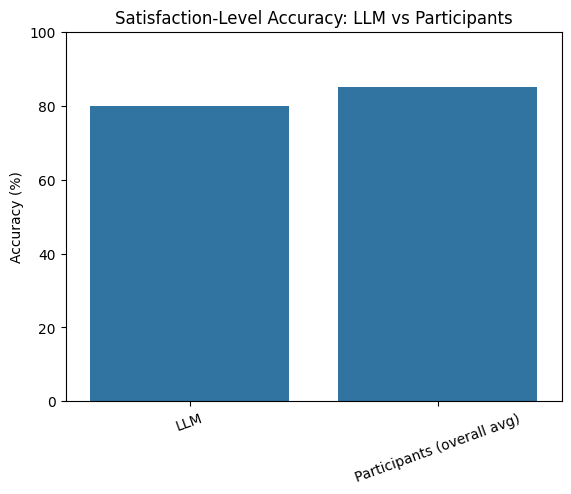

In [23]:
rows = [
    {'who': 'LLM', 'accuracy_percent': accuracy},
    {'who': 'Participants (overall avg)', 'accuracy_percent': user_accuracy},
]
accuracy_compare = pd.DataFrame(rows)

sns.barplot(data=accuracy_compare, x='who', y='accuracy_percent')
plt.title('Satisfaction-Level Accuracy: LLM vs Participants')
plt.ylabel('Accuracy (%)')
plt.xlabel('')
plt.ylim(0, 100)
plt.xticks(rotation=20)
plt.show()

LLM macro F1 (satisfaction): 0.783
Participants macro F1 (satisfaction): 0.824


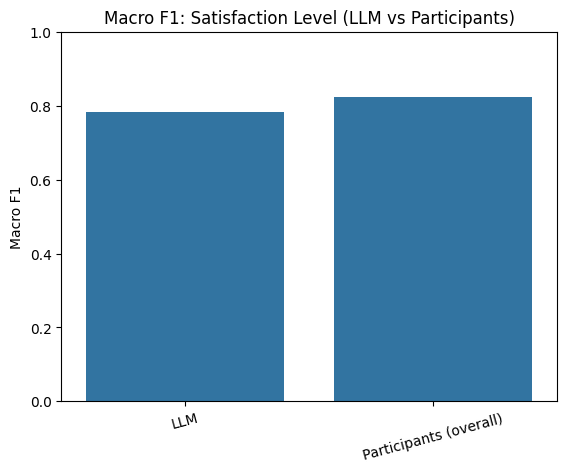

In [24]:
from sklearn.metrics import f1_score

df_comparison = df_ground_truth[['nfr_id', 'satisfaction_level']].merge(
    df_llm_response[['nfr_id', 'satisfaction_level']],
    on='nfr_id',
    suffixes=('_gt', '_llm')
)

macro_f1_llm = f1_score(
    df_comparison['satisfaction_level_gt'],
    df_comparison['satisfaction_level_llm'],
    average='macro'
)

user_gt = df_participant_nfr[['participant_id', 'nfr_id', 'participant_satisfaction_level']].merge(
    df_ground_truth[['nfr_id', 'satisfaction_level']],
    on='nfr_id',
    suffixes=('_user', '_gt')
)

macro_f1_users = f1_score(
    user_gt['satisfaction_level'],
    user_gt['participant_satisfaction_level'],
    average='macro'
)

print(f"LLM macro F1 (satisfaction): {macro_f1_llm:.3f}")
print(f"Participants macro F1 (satisfaction): {macro_f1_users:.3f}")

f1_compare = pd.DataFrame(
    [
        {'who': 'LLM', 'macro_f1': macro_f1_llm},
        {'who': 'Participants (overall)', 'macro_f1': macro_f1_users},
    ]
 )

sns.barplot(data=f1_compare, x='who', y='macro_f1')
plt.title('Macro F1: Satisfaction Level (LLM vs Participants)')
plt.ylabel('Macro F1')
plt.xlabel('')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.show()

Cohen's kappa (LLM vs ground truth): 0.741
Cohen's kappa (Participants vs ground truth): 0.807


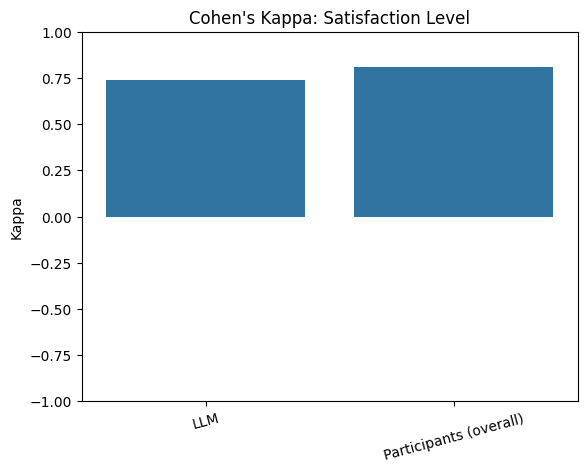

In [25]:
kappa_llm = cohen_kappa_score(df_comparison['satisfaction_level_gt'], df_comparison['satisfaction_level_llm'])
kappa_users = cohen_kappa_score(user_gt['satisfaction_level'], user_gt['participant_satisfaction_level'])

print(f"Cohen's kappa (LLM vs ground truth): {kappa_llm:.3f}")
print(f"Cohen's kappa (Participants vs ground truth): {kappa_users:.3f}")

kappa_compare = pd.DataFrame([
    {'who': 'LLM', 'kappa': kappa_llm},
    {'who': 'Participants (overall)', 'kappa': kappa_users},
])

sns.barplot(data=kappa_compare, x='who', y='kappa')
plt.title("Cohen's Kappa: Satisfaction Level")
plt.ylabel('Kappa')
plt.xlabel('')
plt.ylim(-1, 1)
plt.xticks(rotation=15)
plt.show()

### Reasoning

In [26]:
# ROUGE
# BERTScore

### Code Location

In [27]:
# TBD

# RQ2

## generate data

In [ ]:
N = 270

data = {
    # Task Success
    'kappa': np.clip(np.random.normal(0.82, 0.12, N), 0.4, 1.0), #todo
    
    # Efficiency Costs
    'MET': np.random.gamma(2, 8, N),  # Mean Elapsed Time (minutes)
    'MUM': np.random.poisson(14, N),   # Mean User Moves
    
    # Quality Costs (Standard)
    'Comp': np.random.binomial(1, 0.7, N),  # Task Completion
    'NUI': np.random.poisson(10, N),         # Number of User Initiatives
    'MWT': np.random.gamma(3, 6, N),         # Mean Words per Turn
    'MRT': np.random.gamma(2, 2.5, N),       # Mean Response Time (sec)
    'NMR': np.random.poisson(1.5, N),        # Number of Missing Responses
    'NUR': np.random.poisson(2, N),          # Number of Unsuitable Requests
    'NIR': np.random.poisson(3, N),          # Number of Inappropriate Responses
    'Error': np.random.poisson(0.3, N),      # Number of Errors
    
    # Quality Costs (NFR-Specific)
    'NCQ': np.random.poisson(4, N),   # Number of Clarification Questions
    'CSR': np.random.poisson(4, N),   # Code Snippet Requests
    'FAR': np.random.beta(5, 2, N),   # Files Analyzed Ratio
    'NUE': np.random.poisson(3, N),   # Number of Uncertainty Expressions
    'NHT': np.random.poisson(8, N),   # Number of HIPAA Terms
    'RAC': np.random.poisson(3, N),   # Requests for Additional Context
}
df = pd.DataFrame(data)

,kappa,MET,MUM,Comp,NUI,MWT,MRT,NMR,NUR,NIR,Error,NCQ,CSR,FAR,NUE,NHT,RAC
0,0.794143,28.073173,10,1,12,17.729631,3.432652,2,2,1,0,3,2,0.767879,1,8,3
1,0.726583,12.266926,11,1,13,30.075869,2.692956,1,4,2,0,3,3,0.728532,6,7,6
2,0.840740,24.306426,20,0,11,23.642876,7.266196,2,0,6,0,6,5,0.698511,0,3,1
3,0.790010,14.699828,10,1,6,31.058068,4.466459,1,3,2,0,7,2,0.921964,7,12,4
4,0.983423,19.384506,11,0,6,21.673548,0.592003,1,3,2,0,2,4,0.920621,4,5,3


In [35]:
base_satisfaction = 20 + 10 * df['kappa']  # Base: 16-30
us_total = (base_satisfaction 
            - 0.5 * df['NIR']      # Inappropriate responses hurt
            - 0.3 * df['NUR']      # Unsuitable requests hurt
            - 0.2 * df['MUM']      # More moves = harder task
            - 0.3 * df['NUE']      # Uncertainty hurts
            + 2 * df['Comp']       # Completion helps
            + np.random.normal(0, 2, N))  # Add noise

df['US_Total'] = np.clip(np.round(us_total), 8, 40).astype(int)
df.head()

,kappa,MET,MUM,Comp,NUI,MWT,MRT,NMR,NUR,NIR,Error,NCQ,CSR,FAR,NUE,NHT,RAC,US_Total
0,0.794143,28.073173,10,1,12,17.729631,3.432652,2,2,1,0,3,2,0.767879,1,8,3,30
1,0.726583,12.266926,11,1,13,30.075869,2.692956,1,4,2,0,3,3,0.728532,6,7,6,23
2,0.840740,24.306426,20,0,11,23.642876,7.266196,2,0,6,0,6,5,0.698511,0,3,1,21
3,0.790010,14.699828,10,1,6,31.058068,4.466459,1,3,2,0,7,2,0.921964,7,12,4,26
4,0.983423,19.384506,11,0,6,21.673548,0.592003,1,3,2,0,2,4,0.920621,4,5,3,24


##

In [ ]:
from scipy import stats
predictors = ['kappa', 'MET', 'MUM', 'Comp', 'NUI', 'MWT', 'MRT', 'NMR', 
              'NUR', 'NIR', 'Error', 'NCQ', 'CSR', 'FAR', 'NUE', 'NHT', 'RAC']
target = 'US_Total'

# Z-score normalization
scaler = StandardScaler()
X = scaler.fit_transform(df[predictors])
y = scaler.fit_transform(df[[target]]).flatten()

# Fit linear regression
model = LinearRegression()
model.fit(X, y)

# Calculate statistics
n = len(y)
p = len(predictors)
y_pred = model.predict(X)
residuals = y - y_pred
RSS = np.sum(residuals**2)
MSE = RSS / (n - p - 1)

# Calculate R²
R2 = model.score(X, y)

# Calculate p-values for each coefficient
var_coef = MSE * np.linalg.inv(X.T @ X).diagonal()
se_coef = np.sqrt(var_coef)
t_stats = model.coef_ / se_coef
p_values = [2 * (1 - stats.t.cdf(abs(t), n - p - 1)) for t in t_stats]

print("PERFORMANCE FUNCTION")

equation_parts = []
for i, pred in enumerate(predictors):
    coef = model.coef_[i]
    sign = '+' if coef >= 0 else '-'
    equation_parts.append(f"{sign} {abs(coef):.2f}·N({pred})")

equation = "N(US_Total) = " + " ".join(equation_parts)
print(equation)

print(f"\nR² = {R2:.3f} ({R2*100:.1f}% of variance explained)")



PERFORMANCE FUNCTION

N(US_Total) = + 0.38·N(kappa) - 0.04·N(MET) - 0.22·N(MUM) + 0.37·N(Comp) + 0.00·N(NUI) + 0.05·N(MWT) + 0.14·N(MRT) - 0.02·N(NMR) - 0.16·N(NUR) - 0.34·N(NIR) - 0.00·N(Error) - 0.04·N(NCQ) - 0.02·N(CSR) - 0.04·N(FAR) - 0.16·N(NUE) - 0.04·N(NHT) - 0.00·N(RAC)

R² = 0.561 (56.1% of variance explained)


/opt/miniconda3/envs/dialogue/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/opt/miniconda3/envs/dialogue/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/opt/miniconda3/envs/dialogue/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/opt/miniconda3/envs/dialogue/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/opt/miniconda3/envs/dialogue/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/opt/miniconda3/envs/dialogue/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280:

In [43]:
var_coef

array([0.00190923, 0.00181824, 0.00182339, 0.00190346, 0.00189545,
       0.00189343, 0.00186384, 0.00189607, 0.00188877, 0.00188452,
       0.00181855, 0.00183766, 0.00183237, 0.00190948, 0.00192862,
       0.00182722, 0.00178522])

In [41]:
print(f"\n{'='*80}")
print("SIGNIFICANT PREDICTORS (p < 0.05)")
print(f"{'='*80}\n")

results = pd.DataFrame({
    'Predictor': predictors,
    'Coefficient': model.coef_,
    'P-value': p_values,
    'Significant': ['***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else '' 
                    for p in p_values]
})

# Sort by p-value
results = results.sort_values('P-value')
# Print only significant ones
significant = results[results['P-value'] < 0.05].copy()
print(significant.to_string(index=False))
print("\n*** p<0.001, ** p<0.01, * p<0.05")


SIGNIFICANT PREDICTORS (p < 0.05)

Predictor  Coefficient      P-value Significant
    kappa     0.376885 6.661338e-16         ***
     Comp     0.370864 1.554312e-15         ***
      NIR    -0.341207 1.119105e-13         ***
      MUM    -0.221087 4.600124e-07         ***
      NUE    -0.162055 2.746931e-04         ***
      NUR    -0.155767 4.059364e-04         ***
      MRT     0.136965 1.698656e-03          **

*** p<0.001, ** p<0.01, * p<0.05


In [42]:
print(f"\n{'='*80}")
print("ANSWER TO RQ2")
print(f"{'='*80}\n")

print("RQ2: What dialogue metrics significantly correlate with user satisfaction?\n")

if len(significant) > 0:
    print(f"The performance function explained {R2*100:.1f}% of variance in user")
    print(f"satisfaction (R²={R2:.3f}). The following dialogue metrics were")
    print(f"statistically significant predictors (p < 0.05):\n")
    
    for _, row in significant.iterrows():
        direction = "positively" if row['Coefficient'] > 0 else "negatively"
        print(f"  • {row['Predictor']:20s} (β={row['Coefficient']:+.3f}, p={row['P-value']:.4f}) - {direction} correlated")
    
    # Categorize predictors
    task_success = [p for p in significant['Predictor'] if p == 'kappa']
    efficiency = [p for p in significant['Predictor'] if p in ['MET', 'MUM']]
    quality_std = [p for p in significant['Predictor'] if p in ['Comp', 'NUI', 'MWT', 'MRT', 'NMR', 'NUR', 'NIR', 'Error']]
    quality_nfr = [p for p in significant['Predictor'] if p in ['NCQ', 'CSR', 'FAR', 'NUE', 'NHT', 'RAC']]
    
    print(f"\nBreakdown by category:")
    if task_success:
        print(f"  • Task Success: {', '.join(task_success)}")
    if efficiency:
        print(f"  • Efficiency Costs: {', '.join(efficiency)}")
    if quality_std:
        print(f"  • Quality Costs (Standard): {', '.join(quality_std)}")
    if quality_nfr:
        print(f"  • Quality Costs (NFR-Specific): {', '.join(quality_nfr)}")
else:
    print("No significant predictors found (p < 0.05)")



ANSWER TO RQ2

RQ2: What dialogue metrics significantly correlate with user satisfaction?

The performance function explained 56.1% of variance in user
satisfaction (R²=0.561). The following dialogue metrics were
statistically significant predictors (p < 0.05):

  • kappa                (β=+0.377, p=0.0000) - positively correlated
  • Comp                 (β=+0.371, p=0.0000) - positively correlated
  • NIR                  (β=-0.341, p=0.0000) - negatively correlated
  • MUM                  (β=-0.221, p=0.0000) - negatively correlated
  • NUE                  (β=-0.162, p=0.0003) - negatively correlated
  • NUR                  (β=-0.156, p=0.0004) - negatively correlated
  • MRT                  (β=+0.137, p=0.0017) - positively correlated

Breakdown by category:
  • Task Success: kappa
  • Efficiency Costs: MUM
  • Quality Costs (Standard): Comp, NIR, NUR, MRT
  • Quality Costs (NFR-Specific): NUE
